In [54]:

import numpy as np
import torch
from torch import nn, optim
from torchvision import datasets,transforms
from torch.utils.data import DataLoader, random_split
import timm
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [84]:
# step 1: prepare the dataset

# setup the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.255),
    transforms.ColorJitter(brightness=0.1, contrast=0.0, saturation=0.0, hue= 0),
    transforms.RandomRotation(15),
    transforms.Resize((224,224)),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])


# load the dataset
skin_path = r'C:\Users\OYEE_jUNIOR\Desktop\Skin_con\skin'
dataset = datasets.ImageFolder(root = skin_path, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

# setup the data loader
train_loader = DataLoader(train_data, batch_size=32, shuffle = True)
test_loader = DataLoader(test_data, batch_size=32, shuffle = True)

In [86]:
def visualize_image(image_index):
    image = np.transpose(train_data[image_index][0],(1,2,0))
    label =train_data[image_index][1]
    plt.imshw(image)
    plt.title(f'this is image of {label}')
    plt.show
    
    visualize_image(1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.637033].


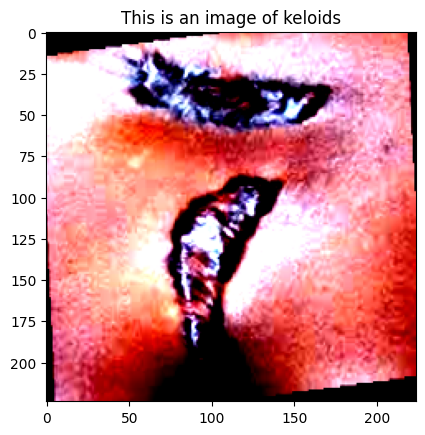

In [78]:
# visualize the data
skin_con = ['Boil','clear skin','Eczema','keloids','Vitiligo']
def visualize_image(image_index):
  image = np.transpose(train_data[image_index][0], (1,2,0))
  plt.imshow(image)
  plt.title(f'This is an image of {skin_con[train_data[image_index][1]]}')

visualize_image(290)

In [ ]:
# setup the model

# setup the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = timm.create_model('efficientnet_b3', pretrained=True)
model.classifier = nn.Linear(in_features=model.classifier.in_features, out_features=5)
model = model.to(device)


# define the hyper-parameters of the model

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(params = model.parameters(), lr = 1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=3,  gamma=0.1)
epochs = 10

In [ ]:
# set up the training loop

model.train()
all_labels = []
all_preds = []
loss_list = []

for epoch in range(epochs):
  progress_bar = tqdm(train_loader, desc = f'Training Epoch: {epoch + 1}/{epochs}')
  for images, labels in progress_bar:
    images, labels = images.to(device), labels.to(device)
    # forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    outputs_preds = outputs.argmax(dim = 1)
    all_preds.extend(outputs_preds.cpu().detach().numpy())
    all_labels.extend(labels.cpu().detach().numpy())

  scheduler.step()
  progress_bar.set_postfix(loss = loss.item())


Training Epoch: 10/10: 100%|██████████| 19/19 [19:00<00:00, 60.00s/it]


In [61]:
print(all_labels[:6])

all_labels = [skin_con[i] for i in all_labels]
all_preds = [skin_con[i] for i in all_preds]

print(all_labels[:6])

print(classification_report(all_labels, all_preds))

[np.int64(4), np.int64(0), np.int64(1), np.int64(4), np.int64(1), np.int64(3)]
['Vitiligo', 'Boil', 'clear skin', 'Vitiligo', 'clear skin', 'keloids']
              precision    recall  f1-score   support

        Boil       0.86      0.85      0.85      1100
      Eczema       0.85      0.80      0.82      1200
    Vitiligo       0.82      0.82      0.82      1240
  clear skin       0.86      0.89      0.87      1210
     keloids       0.84      0.87      0.85      1240

    accuracy                           0.85      5990
   macro avg       0.85      0.85      0.85      5990
weighted avg       0.85      0.85      0.85      5990



In [80]:
from PIL import Image

def predict(image_path):

  image = Image.open(image_path).convert('RGB')
  image = transform(image).unsqueeze(0).to(device)

  with torch.no_grad():
    outputs = model(image)
    prediction = outputs.argmax(dim = 1).item()

  print(f'The prediction is: {skin_con[prediction]}')
  


<Axes: >

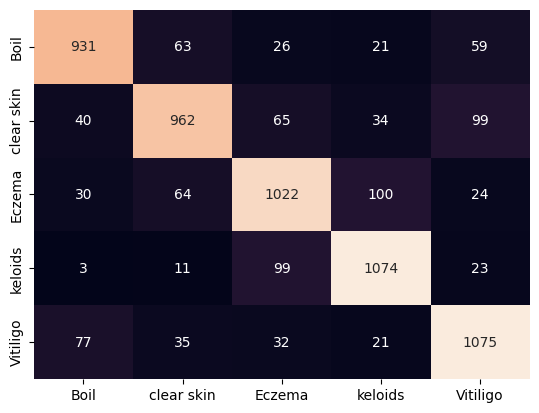

In [ ]:
# classification report
from sklearn.metrics import confusion_matrix

import pandas as pd
conf_matrix = pd.DataFrame(data = confusion_matrix(all_labels, all_preds), columns=skin_con, index=skin_con)
sns.heatmap(data = conf_matrix, annot = True, fmt = 'd', cbar = False)

In [64]:
#evaluation
# validate the loop

model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    outputs_preds = outputs.argmax(dim = 1)
    test_preds.extend(outputs_preds.cpu().detach().numpy())
    test_labels.extend(labels.cpu().detach().numpy())


c:\Users\OYEE_jUNIOR\Desktop\Skin_con\skin_env\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


<Axes: >

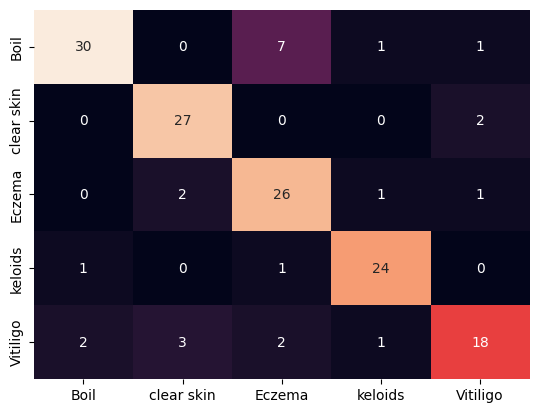

In [65]:
conf_matrix = pd.DataFrame(data = confusion_matrix(test_labels, test_preds), columns=skin_con, index=skin_con)
sns.heatmap(data = conf_matrix, annot = True, fmt = 'd', cbar = False)

In [ ]:
#torch.save(model, "skin_condition_+.pth")

from torch import nn

softmax = nn.Softmax(dim=1)

# Function to classify a single image
def classify_condition(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Perform inference
    with torch.no_grad():
        outputs = model(image)
        outputs = softmax(outputs)
        probability, predicted = torch.max(outputs, 1)

    # Map the prediction to class names
    skin_con = ['Acne','Enzema','Keloids','Vitiligo','clear skin'] # Adjust to your class names
    return skin_con[predicted.item()], probability



# Example usage
image_path = r'/content/drive/MyDrive/Skin care Project'  # Replace with the path to your image
predicted_class, probability = classify_condition(image_path)
print(f"The predicted skin condition is: {predicted_class} with probability of: {round(probability.item(), 3)}")

from PIL import Image
import torch
import torchvision.transforms as transforms
import timm

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the saved model
model = timm.create_model('efficientnet_b3', pretrained=False)
model.classifier = torch.nn.Linear(model.classifier.in_features, 2)  # Adjust for 2 classes

model = model.to(device)
model.eval()

# Define the transformation (same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])